In [1]:
!pwd

/dli/task/ComParE2022_VecNet/notebooks/DK


In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [3]:
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_1.zip?download=1
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_2.zip?download=1
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_3.zip?download=1
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_4.zip?download=1

In [4]:
# !unzip /content/humbugdb_neurips_2021_1.zip?download=1 -d '/content/HumBugDB/data/audio'
# !unzip /content/humbugdb_neurips_2021_2.zip?download=1 -d '/content/HumBugDB/data/audio'
# !unzip /content/humbugdb_neurips_2021_3.zip?download=1 -d '/content/HumBugDB/data/audio'
# !unzip /content/humbugdb_neurips_2021_4.zip?download=1 -d '/content/HumBugDB/data/audio'

In [5]:
!pip install torch_audiomentations
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
from torch_audiomentations import Compose,AddBackgroundNoise , AddColoredNoise , ApplyImpulseResponse,PeakNormalization,TimeInversion

In [7]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [8]:
# other dependencies
#!pip install timm ipywidgets

In [9]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [10]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [11]:
!pwd

/dli/task/ComParE2022_VecNet/notebooks/DK


In [12]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../../src'))
import config ,config_pytorch
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [13]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [14]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization


In [15]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [16]:
#torch.autograd.set_detect_anomaly(True)

In [17]:
#Global Training variables 
USE_SHORT_AUDIO = True
num_workers=8
pin_memory=True
#train_size = 100
batch_size = 32
test_batch_size = 32
DEBUG = False
if DEBUG:
    batch_size = 4
    test_batch_size = 4
    num_workers=1
    
     

num_epochs = 200

In [18]:
# This function creates 1.92 secs rows of audio in a data frame format
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [19]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]


### Read CSV and get train/test groups

In [20]:
# if DEBUG:
#     df = pd.read_csv(config.data_df_msc_test)
# else:
df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,1/7/2018 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,1/7/2018 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,1/7/2018 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,1/7/2018 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [21]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"



In [22]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
# other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
# df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [23]:
df.drop(df[df['specie_ind'] == "NULL_VAL"].index, inplace=True)
#other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
#df.loc[other_df_ind,'specie_ind']= other_ind        

At this stage we have all extracted the data with specie information and have encoded the specie encoding in a col = 'specie_ind'

In [24]:
#extracting the TZ and Cup data- this is as per the humbug paper

idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_all = df[idx_multiclass]

In [25]:
df_all.reset_index(inplace=True)

In [26]:
df_all

,index,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1879,221103,2.56,IFA_17_24_664.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,1880,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
2,1881,221110,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
3,1882,221149,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
4,1883,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,4546,222615,30.72,IFA_86_39_3439.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
2284,4547,222585,25.60,IFA_86_40_3440.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
2285,4548,222586,40.90,IFA_87_10_3450.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
2286,4549,222596,40.90,IFA_87_11_3451.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3


### Train-Test split( avoiding sklearn )

In [27]:
np.random.seed(42)
msk_test = np.random.rand(len(df_all)) < 0.2
df_test = df_all[msk_test]
df_train_temp  = df_all[~msk_test]


In [28]:
np.random.seed(42)
msk_train = np.random.rand(len(df_train_temp)) < 0.2
df_val = df_train_temp[msk_train]
df_train  = df_train_temp[~msk_train]

## Let's verify for data leakage by performing an inner-join on id

In [29]:
pd.merge(df_test,df_train, on = 'id', how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


In [30]:
pd.merge(df_test,df_val, on = 'id', how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


In [31]:
pd.merge(df_train,df_val, on = 'id', how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


We've confirmed that there is no recording that is common in Train,Test,val

### Next, we perform "offsets", spliting each(long) recording into multiple 1.92 secs chunk. 

In [32]:
df_train_offset = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
df_test_offset = get_offsets_df(df_test, short_audio=USE_SHORT_AUDIO)
df_val_offset = get_offsets_df(df_val, short_audio=USE_SHORT_AUDIO)

In [33]:
print("length of train offset = " +str(len(df_train_offset)))
print("length of test offset = " +str(len(df_test_offset)))
print("length of val offset = " +str(len(df_val_offset)))

length of train offset = 32239
length of test offset = 10087
length of val offset = 8692


In [34]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



### Let's check for data leakage in offsets

In [35]:
pd.merge(df_train_offset , df_test_offset , on = 'id', how = 'inner')

,index_x,id,offset_x,length_x,specie_ind_x,index_y,offset_y,length_y,specie_ind_y


In [36]:
pd.merge(df_train_offset , df_val_offset , on = 'id', how = 'inner')

,index_x,id,offset_x,length_x,specie_ind_x,index_y,offset_y,length_y,specie_ind_y


In [37]:
pd.merge(df_test_offset , df_val_offset , on = 'id', how = 'inner')

,index_x,id,offset_x,length_x,specie_ind_x,index_y,offset_y,length_y,specie_ind_y


### At this stage we've a dataframe of recordin ids and each row corresponds to a 1.92 secs recording or shorter


In [38]:
def get_specie_distri(df , classes , type_df = None):
    """This function takes a dataframe and provides a count of each specie class"""
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [39]:
#Class imbalance 
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.32298429 0.56615271 3.6109991  0.61779473 1.98809817 4.24197368
 3.08802682 5.57382434]


Let us now get the class distribution for each of the dataframes- train,test and val

In [40]:
get_specie_distri(df_train_offset , classes , type_df = "train")


DF type = train
i = 0
12477
DF type = train
i = 1
7118
DF type = train
i = 2
1116
DF type = train
i = 3
6523
DF type = train
i = 4
2027
DF type = train
i = 5
950
DF type = train
i = 6
1305
DF type = train
i = 7
723


In [41]:
get_specie_distri(df_val_offset , classes , type_df = "Val")

DF type = Val
i = 0
3613
DF type = Val
i = 1
1994
DF type = Val
i = 2
230
DF type = Val
i = 3
1855
DF type = Val
i = 4
280
DF type = Val
i = 5
228
DF type = Val
i = 6
426
DF type = Val
i = 7
66


In [42]:
get_specie_distri(df_test_offset , classes , type_df = "test")

DF type = test
i = 0
4356
DF type = test
i = 1
1879
DF type = test
i = 2
439
DF type = test
i = 3
1959
DF type = test
i = 4
507
DF type = test
i = 5
312
DF type = test
i = 6
441
DF type = test
i = 7
194


In [43]:
# This function pads a short-audio tensor with its mean to ensure that it becomes a 1.92 sec long audio equivalent
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add))
        print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add))
        print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [44]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(len(classes)))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [45]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### Class Defintions

In [46]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [47]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [48]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,0,221103,0,2.56,7
1,1,221111,0,2.56,7
2,2,221110,0,2.56,7
3,3,221149,0,2.56,0
4,4,221144,0,2.56,1


In [49]:
def get_error_df(loader , trained_model, DEBUG = False):
    err_dict = {'id': None,
               'label': None,
               'offset':None,
               'y_hat':None}
    model = trained_model
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        all_wav_id = []
        all_offset = []
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y,offset,wav_id) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                print("y = " + str(y))
                print("offset = " + str(offset))
                print("wav_id = " + str(wav_id))
                
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
            all_y.append(y.cpu().detach())
            all_wav_id.append(wav_id.cpu().detach())
            all_offset.append(offset.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y).numpy()
        all_y_pred = torch.cat(all_y_pred)
        all_wav_id = torch.cat(all_wav_id)
        all_offset = torch.cat(all_offset)
        
        err_dict['id'] = all_wav_id
        err_dict['label'] = all_y
        err_dict['offset'] = all_offset
        err_dict['y_hat'] = all_y_pred
        df_err = pd.DataFrame.from_dict(err_dict)
        df_err_uniq = df_err[df_err['label']!= df_err['y_hat']]
        df_err_uniq.sort_values(by=['id','offset'])

        
        
        
        if DEBUG:
            print("inside error ....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        #test_loss = test_loss/len(test_loader)
        #test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return df_err_uniq

In [50]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    softmax = nn.Softmax()
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            y_pred_smax = softmax(y_pred)
            preds = torch.argmax(y_pred_smax, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred

In [51]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    optimiser = timm.optim.create_optimizer_v2(model.parameters(), lr=config_pytorch.lr/100,opt = 'lookahead_adam')
    #optimiser = timm.optim.AdamW(model.parameters(), lr=config_pytorch.lr)
    timm.optim.Lookahead(optimiser, alpha=0.5, k=6)
    
    #optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    softmax = nn.Softmax()
    all_train_f1 = []
    all_val_f1 = []
    
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        #tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(train_loader):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 200 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            y = inputs[1].type(torch.LongTensor).to(device)
            #global_step += 1
            # AMP
            x_sum = torch.sum(x,axis = 1)
            x_sum.unsqueeze(dim = 1)
            zero_chk = torch.where((x_sum == 0))[0]
            if len(zero_chk) > 0:
                print("ZERO ENCOUNTER")
                print("x = " +str(x))
                break
                       
            with autocast():
                y_pred = model(x)['prediction']
                y_pred_smax = softmax(y_pred)
                preds = torch.argmax(y_pred_smax, axis = 1)
                loss = criterion(y_pred, y)
            
            if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                
                
            #loss_scaler(loss, optimiser,parameters=model_parameters(model))
            if loss.item() > 10000:
                print("^^^^^^^^^^^^^^^^^ EXPLOSION^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
                print("x sum = " + str(torch.sum(x)))
                print("current loss = " + str(loss.item()))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            optimiser.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),error_if_nonfinite=False ,max_norm = 5.0 )
            optimiser.step()
            del x
            del y
            del y_pred,preds
        
        #lr_log.append(lr)
        optimiser.sync_lookahead()
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        all_train_f1.append(train_f1)
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        all_val_f1.append(val_f1)
        all_val_loss.append(val_loss)
        if DEBUG:
            print("val F1 = " + str(val_f1))
        all_val_loss.append(val_loss)
        all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        if acc_metric > best_acc_metric:  
            overrun_counter = -1
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir,  checkpoint_name))
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
            print('Saving model to:', os.path.join(config.model_dir,  checkpoint_name)) 
            print("Now printing classification rport... ")
            print("********************************")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            # at times output is not getting printed. Could be due to multi threading and hence adding sleep
            time.sleep(2)
            sys.stdout.flush()
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            print("********************************")
            time.sleep(2)
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_f1 = val_f1
            best_val_loss = val_loss
            
        else:
            print("..Overrun....no improvement")
            overrun_counter += 1
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1

In [52]:
# from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization
# #apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])


# apply_augmentation = Compose(transforms=[AddColoredNoise(p = 1) ,TimeInversion( p = 1) ,PolarityInversion(p = 1)])

# #apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])

In [53]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
                   
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
       # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("idx = " + str(idx))
            print("offset = " + str(offset))
            print("shape of x post augmentation = " + str(x.shape))
            print("from get_item of train, returning  x of shape = " +str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
        
        x_val = x[:,offset:int(offset+config.rate*self.min_length)]
        if torch.sum(x_val) == 0:
            print("ZERO TENSOR IN DATASET")
            x_val = x_val + torch.tensor(1e-6)
            
        return (x_val,self.audio_df.loc[idx]['specie_ind'] )


In [54]:
class MozErrAnalysisDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'],offset, self.audio_df.loc[idx]['id'])


In [55]:
class MozTestDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("idx = " + str(idx))
            print("shape of x post augmentation = " + str(x.shape))
            print("offset = " + str(offset))
            print("from get_item of train, returning  x of shape = " +str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
            
        x_val = x[:,offset:int(offset+config.rate*self.min_length)]
        if torch.sum(x_val) == 0:
            print("ZERO TENSOR IN DATASET")
            x_val = x_val + torch.tensor(1e-6)
        
        return (x_val,self.audio_df.loc[idx]['specie_ind'] )


In [56]:
def apply_aug(x,rate):
        apply_augmentation = Compose(transforms=[AddColoredNoise(p = .85) ,TimeInversion( p = .75) ,PolarityInversion(p = .25)])
        aug_audio = apply_augmentation(x,sample_rate = rate)
        return(aug_audio)
    

class augment_audio(nn.Module):
    """This is a class to introduce randomness in the data.
    We implement it as a layer in the NN to ensure that it learns from the propertis of the data"""
    def __init__(self , trainable = True, sample_rate = config.rate):
        super().__init__()
        self.trainable = trainable
        self.rate = sample_rate
            
    def forward(self, x):
        x = x.unsqueeze(dim = 1)
           
        if self.trainable:
            x = apply_aug(x , self.rate)
        else:
            x = x
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x.squeeze(dim = 1)

In [57]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=8, in_chans=1, 
                        drop_path_rate=0.2, global_pool='max',
                        drop_rate=0.25)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=True,)
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        #self.augment_layer = augment_audio(trainable = True, sample_rate = config.rate)
        
    def forward(self, x):
        # first compute spectrogram
        if DEBUG:
            print("input shape that goes for augmentation = " + str(x.squeeze().shape))
        #spec = self.augment_layer(x.squeeze())
        if DEBUG:
            print("Out put of augment and input shape that goes for STFT = " + str(x.shape))
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        if DEBUG:
            print("Out put of STFT and input shape that goes for PCEN = " + str(spec.shape))
        spec = self.pcen_layer(spec)
        if DEBUG:
            print("Out put of PCEN and input shape that goes for NORM = " + str(spec.shape))
        spec = self.norm_layer(spec)
        
        if DEBUG:
            print("Out put of NORM and input shape that goes for time mask = " + str(spec.shape))
        spec = self.timeMasking(spec)
        if DEBUG:
            print("Out put of timemask and input shape that goes for freq mask = " + str(spec.shape))
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        if DEBUG:
            print("Final shape that goes to backbone = " + str(x.shape))
        if torch.sum(x) == 0:
            print("ZERO INPUT in forward")
            x  = x+torch.tensor(1e-6)
            
            
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [58]:
print(config.data_dir)
train_dataset = MozTrainDataset(df_train_offset,  config.data_dir, min_length , transform = None)
val_dataset = MozTestDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozTestDataset(df_test_offset,  config.data_dir, min_length)
error_dataset = MozErrAnalysisDataset(df_val_offset,  config.data_dir, min_length = config.min_duration)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )

error_loader = torch.utils.data.DataLoader(
        error_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


../../data/audio


In [59]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 32239
Length of train loader = 1008


In [60]:
# train_itr = iter(train_loader)
# a,b = train_itr.next()
# print(a.shape)
# print(b)

In [61]:
# spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
#                               window='hann', freq_scale='linear', center=True, pad_mode='reflect',
#                            sr=config.rate, output_format="Magnitude", trainable=True,)
# x = spec_layer(a)

In [62]:
#test_mod = Model('convnext_small',224)



In [63]:
# test_mod(a)


## Training

In [64]:
def load_model(filepath, model=Model('convnext_small',224)):
    # Instantiate model to inspect
    print("Filepath = " + str(filepath))
    print("model = " +str(model))
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0786 seconds


In [65]:
timm.list_models('conv*', pretrained= True)

['convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0814 seconds
Training on cuda:0
epoch = 0batch = 0 of 1008duraation = 0.03397314151128133
epoch = 0batch = 200 of 1008duraation = 2.2482705314954123
epoch = 0batch = 400 of 1008duraation = 4.452258288860321
epoch = 0batch = 600 of 1008duraation = 6.653117767969767
epoch = 0batch = 800 of 1008duraation = 8.869352968533834
epoch = 0batch = 1000 of 1008duraation = 11.078252677122752
Epoch: 0, Train Loss: 1.95128937, Train f1: 0.27407639, Val Loss: 0.00524530, Val f1: 0.41474952, overrun_counter -1
Saving model to: ../../models/model_e0_2022_10_09_19_57_41.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.75      0.37      0.49      4356
culex pipiens complex       0.46      0.39      0.42      1879
           ae aegypti       0.23      

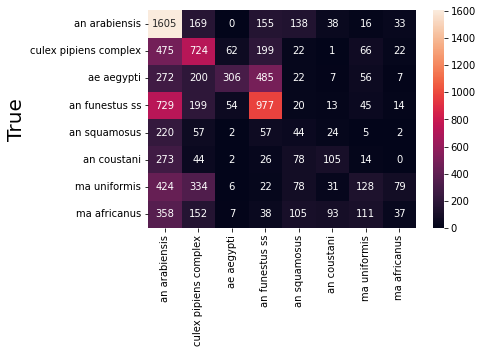

epoch = 1batch = 0 of 1008duraation = 0.03217790126800537
epoch = 1batch = 200 of 1008duraation = 2.252544891834259
epoch = 1batch = 400 of 1008duraation = 4.464537759621938
epoch = 1batch = 600 of 1008duraation = 6.673506470521291
epoch = 1batch = 800 of 1008duraation = 8.885194611549377
epoch = 1batch = 1000 of 1008duraation = 11.085441251595816
Epoch: 1, Train Loss: 1.53517472, Train f1: 0.41375694, Val Loss: 0.00471550, Val f1: 0.46782947, overrun_counter -1
Saving model to: ../../models/model_e1_2022_10_09_20_11_58.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.75      0.34      0.47      4356
culex pipiens complex       0.52      0.45      0.48      1879
           ae aegypti       0.44      0.64      0.52       439
       an funestus ss       0.58      0.65      0.61      1959
         an squamosus       0.10      0.33      0.16       507
          an coustan

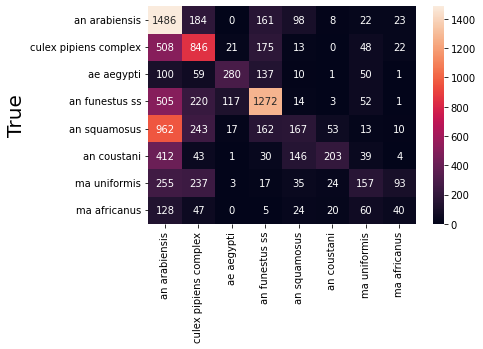

epoch = 2batch = 0 of 1008duraation = 0.031154318650563558
epoch = 2batch = 200 of 1008duraation = 2.2422262986501056
epoch = 2batch = 400 of 1008duraation = 4.446105448404948
epoch = 2batch = 600 of 1008duraation = 6.644547243913014
epoch = 2batch = 800 of 1008duraation = 8.846571008364359
epoch = 2batch = 1000 of 1008duraation = 11.047756326198577
Epoch: 2, Train Loss: 1.30272651, Train f1: 0.48156718, Val Loss: 0.00459674, Val f1: 0.48903986, overrun_counter -1
Saving model to: ../../models/model_e2_2022_10_09_20_26_13.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.81      0.42      0.55      4356
culex pipiens complex       0.51      0.42      0.46      1879
           ae aegypti       0.42      0.79      0.55       439
       an funestus ss       0.61      0.63      0.62      1959
         an squamosus       0.15      0.38      0.22       507
          an coust

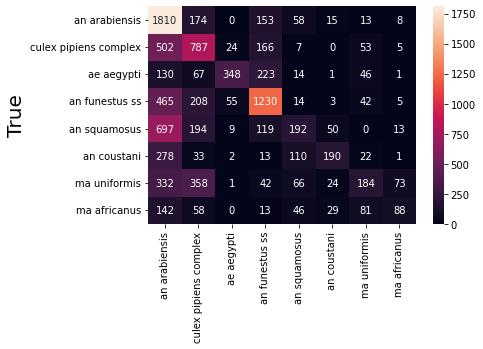

epoch = 3batch = 0 of 1008duraation = 0.033576508363087974
epoch = 3batch = 200 of 1008duraation = 2.2472593704859416
epoch = 3batch = 400 of 1008duraation = 4.447821108500163
epoch = 3batch = 600 of 1008duraation = 6.657164092858633
epoch = 3batch = 800 of 1008duraation = 8.862847900390625
epoch = 3batch = 1000 of 1008duraation = 11.067916055520376
Epoch: 3, Train Loss: 1.14207551, Train f1: 0.52181637, Val Loss: 0.00434278, Val f1: 0.51768951, overrun_counter -1
Saving model to: ../../models/model_e3_2022_10_09_20_40_29.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.78      0.47      0.59      4356
culex pipiens complex       0.48      0.47      0.47      1879
           ae aegypti       0.49      0.70      0.58       439
       an funestus ss       0.65      0.61      0.63      1959
         an squamosus       0.18      0.43      0.26       507
          an coust

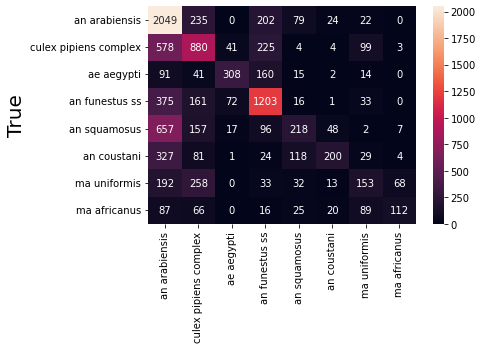

epoch = 4batch = 0 of 1008duraation = 0.03380595048268636
epoch = 4batch = 200 of 1008duraation = 2.248144809405009
epoch = 4batch = 400 of 1008duraation = 4.445505205790202
epoch = 4batch = 600 of 1008duraation = 6.647370843092601
epoch = 4batch = 800 of 1008duraation = 8.86704683303833
epoch = 4batch = 1000 of 1008duraation = 11.066833325227101
Epoch: 4, Train Loss: 1.01813611, Train f1: 0.55638936, Val Loss: 0.00422655, Val f1: 0.54843645, overrun_counter -1
Saving model to: ../../models/model_e4_2022_10_09_20_54_45.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.80      0.49      0.61      4356
culex pipiens complex       0.52      0.50      0.51      1879
           ae aegypti       0.50      0.76      0.60       439
       an funestus ss       0.66      0.64      0.65      1959
         an squamosus       0.18      0.46      0.25       507
          an coustani

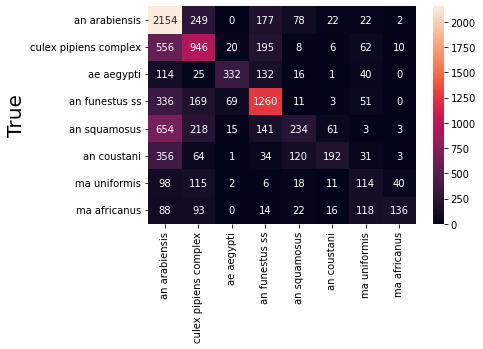

epoch = 5batch = 0 of 1008duraation = 0.033423821131388344
epoch = 5batch = 200 of 1008duraation = 2.2524845639864606
epoch = 5batch = 400 of 1008duraation = 4.45016682545344
epoch = 5batch = 600 of 1008duraation = 6.657615625858307
epoch = 5batch = 800 of 1008duraation = 8.86186952193578
epoch = 5batch = 1000 of 1008duraation = 11.062939389546711
..Overrun....no improvement
Epoch: 5, Train Loss: 0.92468779, Train f1: 0.58750919, Val Loss: 0.00418444, Val f1: 0.54148214, overrun_counter 0
epoch = 6batch = 0 of 1008duraation = 0.0331438422203064
epoch = 6batch = 200 of 1008duraation = 2.254875834782918
epoch = 6batch = 400 of 1008duraation = 4.464660994211832
epoch = 6batch = 600 of 1008duraation = 6.669576247533162
epoch = 6batch = 800 of 1008duraation = 8.87051659822464
epoch = 6batch = 1000 of 1008duraation = 11.069451232751211
Epoch: 6, Train Loss: 0.85147918, Train f1: 0.61147647, Val Loss: 0.00412716, Val f1: 0.56761883, overrun_counter -1
Saving model to: ../../models/model_e6_20

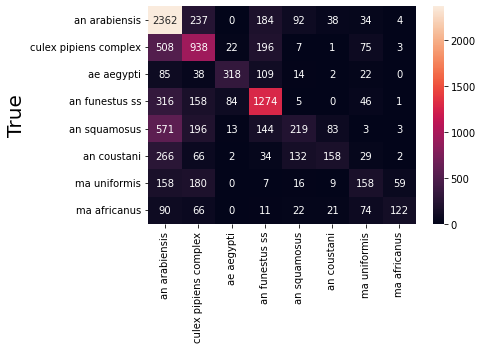

epoch = 7batch = 0 of 1008duraation = 0.033654157320658365
epoch = 7batch = 200 of 1008duraation = 2.2463328003883363
epoch = 7batch = 400 of 1008duraation = 4.444364686806996
epoch = 7batch = 600 of 1008duraation = 6.647033806641897
epoch = 7batch = 800 of 1008duraation = 8.870982086658477
epoch = 7batch = 1000 of 1008duraation = 11.072585932413737
..Overrun....no improvement
Epoch: 7, Train Loss: 0.76525244, Train f1: 0.63707801, Val Loss: 0.00414635, Val f1: 0.56367481, overrun_counter 0
epoch = 8batch = 0 of 1008duraation = 0.03473416964213053
epoch = 8batch = 200 of 1008duraation = 2.255700945854187
epoch = 8batch = 400 of 1008duraation = 4.463463755448659
epoch = 8batch = 600 of 1008duraation = 6.666538429260254
epoch = 8batch = 800 of 1008duraation = 8.875113515059153
epoch = 8batch = 1000 of 1008duraation = 11.084164039293926
Epoch: 8, Train Loss: 0.70178981, Train f1: 0.66362651, Val Loss: 0.00409611, Val f1: 0.58393135, overrun_counter -1
Saving model to: ../../models/model_e

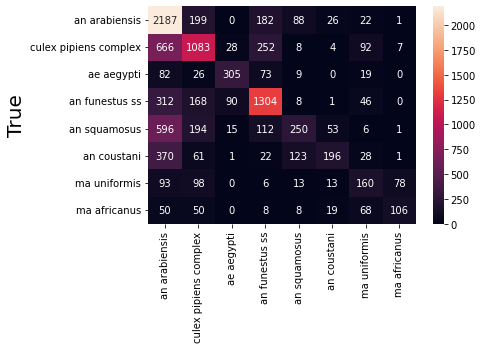

epoch = 9batch = 0 of 1008duraation = 0.03473788499832153
epoch = 9batch = 200 of 1008duraation = 2.2496176799138388
epoch = 9batch = 400 of 1008duraation = 4.461442863941192
epoch = 9batch = 600 of 1008duraation = 6.667964013417562
epoch = 9batch = 800 of 1008duraation = 8.880577131112416
epoch = 9batch = 1000 of 1008duraation = 11.080672840277353
Epoch: 9, Train Loss: 0.64333276, Train f1: 0.68336137, Val Loss: 0.00381860, Val f1: 0.59435134, overrun_counter -1
Saving model to: ../../models/model_e9_2022_10_09_22_02_31.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.75      0.62      0.68      4356
culex pipiens complex       0.56      0.51      0.53      1879
           ae aegypti       0.65      0.63      0.64       439
       an funestus ss       0.66      0.66      0.66      1959
         an squamosus       0.26      0.46      0.33       507
          an cousta

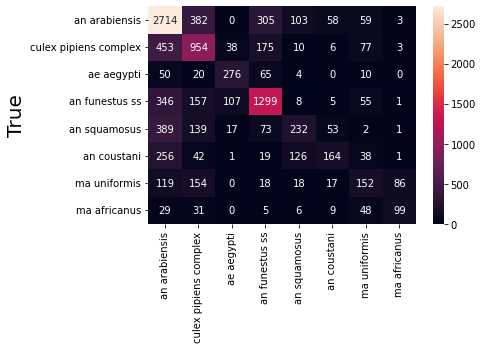

epoch = 10batch = 0 of 1008duraation = 0.03370329936345418
epoch = 10batch = 200 of 1008duraation = 2.254830777645111
epoch = 10batch = 400 of 1008duraation = 4.459900049368541
epoch = 10batch = 600 of 1008duraation = 6.67015186548233
epoch = 10batch = 800 of 1008duraation = 8.879319667816162
epoch = 10batch = 1000 of 1008duraation = 11.069676597913107
..Overrun....no improvement
Epoch: 10, Train Loss: 0.60786428, Train f1: 0.69656058, Val Loss: 0.00425039, Val f1: 0.58158457, overrun_counter 0
epoch = 11batch = 0 of 1008duraation = 0.03161318302154541
epoch = 11batch = 200 of 1008duraation = 2.251965916156769
epoch = 11batch = 400 of 1008duraation = 4.461959858735402
epoch = 11batch = 600 of 1008duraation = 6.670260938008626
epoch = 11batch = 800 of 1008duraation = 8.878076827526092
epoch = 11batch = 1000 of 1008duraation = 11.093291052182515
Epoch: 11, Train Loss: 0.55765522, Train f1: 0.71947008, Val Loss: 0.00412754, Val f1: 0.59967634, overrun_counter -1
Saving model to: ../../mod

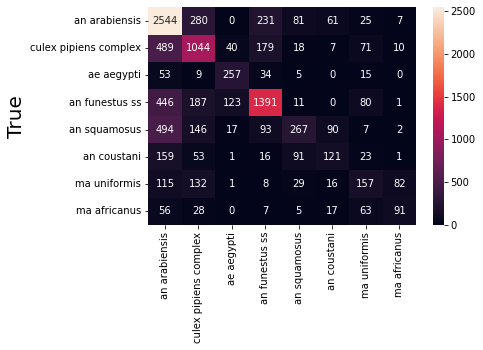

epoch = 12batch = 0 of 1008duraation = 0.029808425903320314
epoch = 12batch = 200 of 1008duraation = 2.251962431271871
epoch = 12batch = 400 of 1008duraation = 4.4470929106076555
epoch = 12batch = 600 of 1008duraation = 6.656961727142334
epoch = 12batch = 800 of 1008duraation = 8.859848829110463
epoch = 12batch = 1000 of 1008duraation = 11.061383497714996
Epoch: 12, Train Loss: 0.52645463, Train f1: 0.73538895, Val Loss: 0.00402293, Val f1: 0.60239552, overrun_counter -1
Saving model to: ../../models/model_e12_2022_10_09_22_43_34.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.79      0.60      0.68      4356
culex pipiens complex       0.52      0.57      0.54      1879
           ae aegypti       0.70      0.67      0.69       439
       an funestus ss       0.65      0.68      0.67      1959
         an squamosus       0.28      0.54      0.36       507
          

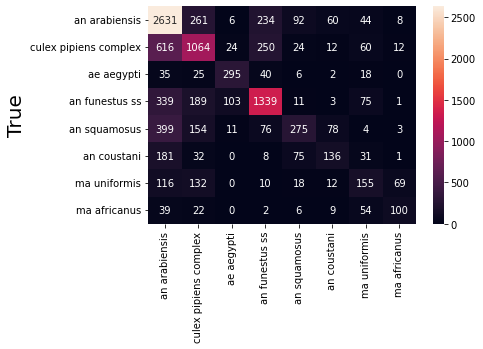

epoch = 13batch = 0 of 1008duraation = 0.033113427956899005
epoch = 13batch = 200 of 1008duraation = 2.247233871618907
epoch = 13batch = 400 of 1008duraation = 4.4602156519889835
epoch = 13batch = 600 of 1008duraation = 6.674329141775767
epoch = 13batch = 800 of 1008duraation = 8.879802759488424
epoch = 13batch = 1000 of 1008duraation = 11.08453775246938
..Overrun....no improvement
Epoch: 13, Train Loss: 0.47012292, Train f1: 0.75731831, Val Loss: 0.00432486, Val f1: 0.59316914, overrun_counter 0
epoch = 14batch = 0 of 1008duraation = 0.029908668994903565
epoch = 14batch = 200 of 1008duraation = 2.2549787123998004
epoch = 14batch = 400 of 1008duraation = 4.464964266618093
epoch = 14batch = 600 of 1008duraation = 6.672759175300598
epoch = 14batch = 800 of 1008duraation = 8.870940828323365
epoch = 14batch = 1000 of 1008duraation = 11.077135821183523
Epoch: 14, Train Loss: 0.44050319, Train f1: 0.76978905, Val Loss: 0.00421671, Val f1: 0.60382354, overrun_counter -1
Saving model to: ../..

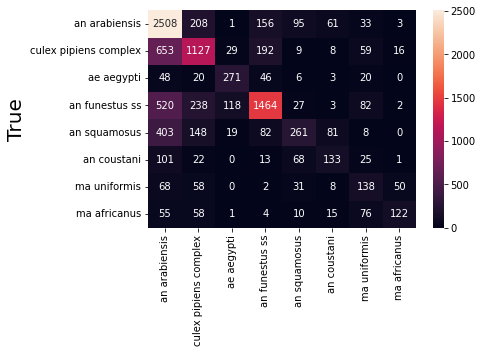

epoch = 15batch = 0 of 1008duraation = 0.03146193027496338
epoch = 15batch = 200 of 1008duraation = 2.2591394066810606
epoch = 15batch = 400 of 1008duraation = 4.467458113034566
epoch = 15batch = 600 of 1008duraation = 6.681751155853272
epoch = 15batch = 800 of 1008duraation = 8.892419866720836
epoch = 15batch = 1000 of 1008duraation = 11.084143658479055
..Overrun....no improvement
Epoch: 15, Train Loss: 0.42317336, Train f1: 0.78252584, Val Loss: 0.00429087, Val f1: 0.60357628, overrun_counter 0
epoch = 16batch = 0 of 1008duraation = 0.02988893191019694
epoch = 16batch = 200 of 1008duraation = 2.2550752997398376
epoch = 16batch = 400 of 1008duraation = 4.457364010810852
epoch = 16batch = 600 of 1008duraation = 6.657929646968841
epoch = 16batch = 800 of 1008duraation = 8.857878915468852
epoch = 16batch = 1000 of 1008duraation = 11.059102626641591
Epoch: 16, Train Loss: 0.39810874, Train f1: 0.79799691, Val Loss: 0.00412859, Val f1: 0.62293534, overrun_counter -1
Saving model to: ../../

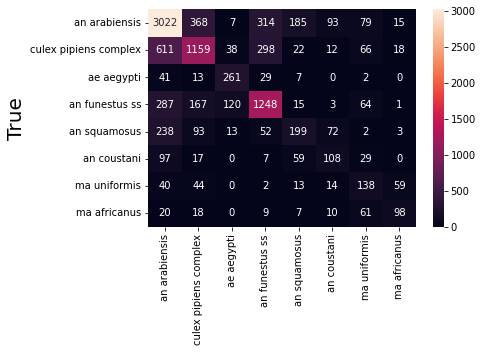

epoch = 17batch = 0 of 1008duraation = 0.029982992013295493
epoch = 17batch = 200 of 1008duraation = 2.2579116185506183
epoch = 17batch = 400 of 1008duraation = 4.47400932709376
epoch = 17batch = 600 of 1008duraation = 6.690893375873566
epoch = 17batch = 800 of 1008duraation = 8.898911293347677
epoch = 17batch = 1000 of 1008duraation = 11.105293317635853
..Overrun....no improvement
Epoch: 17, Train Loss: 0.38349840, Train f1: 0.81043037, Val Loss: 0.00472460, Val f1: 0.60265736, overrun_counter 0
epoch = 18batch = 0 of 1008duraation = 0.029418528079986572
epoch = 18batch = 200 of 1008duraation = 2.261021872361501
epoch = 18batch = 400 of 1008duraation = 4.464839855829875
epoch = 18batch = 600 of 1008duraation = 6.666090766588847
epoch = 18batch = 800 of 1008duraation = 8.877636702855428
epoch = 18batch = 1000 of 1008duraation = 11.088506698608398
Epoch: 18, Train Loss: 0.33143273, Train f1: 0.82506978, Val Loss: 0.00430014, Val f1: 0.62959261, overrun_counter -1
Saving model to: ../../

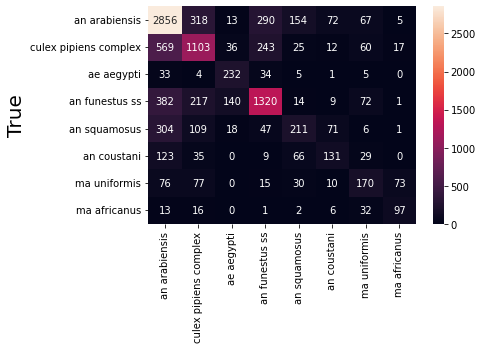

epoch = 19batch = 0 of 1008duraation = 0.032833496729532875
epoch = 19batch = 200 of 1008duraation = 2.2516825278600057
epoch = 19batch = 400 of 1008duraation = 4.4516702651977536
epoch = 19batch = 600 of 1008duraation = 6.6637229760487875
epoch = 19batch = 800 of 1008duraation = 8.877916828791301
epoch = 19batch = 1000 of 1008duraation = 11.093335008621215
..Overrun....no improvement
Epoch: 19, Train Loss: 0.32297322, Train f1: 0.83630104, Val Loss: 0.00437199, Val f1: 0.62329040, overrun_counter 0
epoch = 20batch = 0 of 1008duraation = 0.0346480925877889
epoch = 20batch = 200 of 1008duraation = 2.2604939858118693
epoch = 20batch = 400 of 1008duraation = 4.470441484451294
epoch = 20batch = 600 of 1008duraation = 6.679968019326528
epoch = 20batch = 800 of 1008duraation = 8.885470839341481
epoch = 20batch = 1000 of 1008duraation = 11.079641115665435
..Overrun....no improvement
Epoch: 20, Train Loss: 0.32600191, Train f1: 0.84404461, Val Loss: 0.00476442, Val f1: 0.61263253, overrun_coun

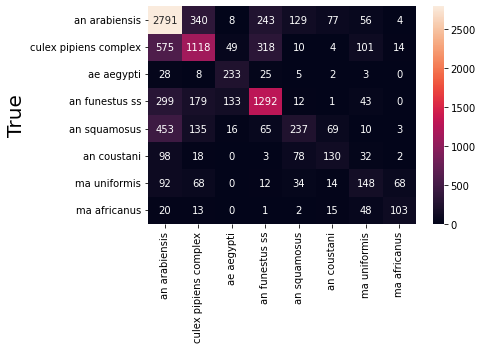

epoch = 22batch = 0 of 1008duraation = 0.031256258487701416
epoch = 22batch = 200 of 1008duraation = 2.2553988615671794
epoch = 22batch = 400 of 1008duraation = 4.472303283214569
epoch = 22batch = 600 of 1008duraation = 6.686404180526734
epoch = 22batch = 800 of 1008duraation = 8.898398697376251
epoch = 22batch = 1000 of 1008duraation = 11.112056843439738
..Overrun....no improvement
Epoch: 22, Train Loss: 0.27040163, Train f1: 0.86754009, Val Loss: 0.00466857, Val f1: 0.63379663, overrun_counter 0
epoch = 23batch = 0 of 1008duraation = 0.03365139563878377
epoch = 23batch = 200 of 1008duraation = 2.2504436135292054
epoch = 23batch = 400 of 1008duraation = 4.459881548086802
epoch = 23batch = 600 of 1008duraation = 6.676489043235779
epoch = 23batch = 800 of 1008duraation = 8.894277048110961
epoch = 23batch = 1000 of 1008duraation = 11.096108222007752
..Overrun....no improvement
Epoch: 23, Train Loss: 0.26177504, Train f1: 0.87494612, Val Loss: 0.00500235, Val f1: 0.62665477, overrun_count

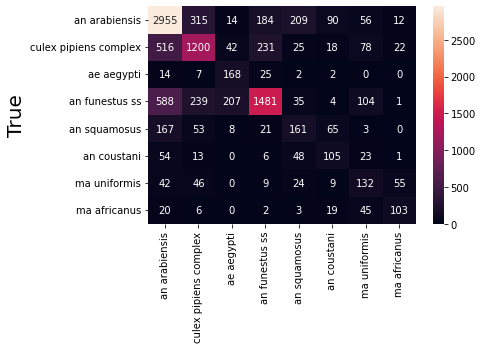

epoch = 26batch = 0 of 1008duraation = 0.033819023768107095
epoch = 26batch = 200 of 1008duraation = 2.249543782075246
epoch = 26batch = 400 of 1008duraation = 4.460393031438191
epoch = 26batch = 600 of 1008duraation = 6.6797611832618715
epoch = 26batch = 800 of 1008duraation = 8.883001403013866
epoch = 26batch = 1000 of 1008duraation = 11.07782754500707
..Overrun....no improvement
Epoch: 26, Train Loss: 0.22218543, Train f1: 0.89621603, Val Loss: 0.00519839, Val f1: 0.62614878, overrun_counter 0
epoch = 27batch = 0 of 1008duraation = 0.02849379777908325
epoch = 27batch = 200 of 1008duraation = 2.250809979438782
epoch = 27batch = 400 of 1008duraation = 4.459273660182953
epoch = 27batch = 600 of 1008duraation = 6.668749860922495
epoch = 27batch = 800 of 1008duraation = 8.875640519460042
epoch = 27batch = 1000 of 1008duraation = 11.08015631834666
..Overrun....no improvement
Epoch: 27, Train Loss: 0.20751120, Train f1: 0.89922084, Val Loss: 0.00537399, Val f1: 0.63464511, overrun_counter 

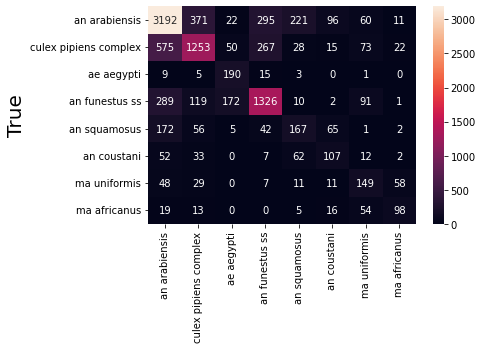

epoch = 31batch = 0 of 1008duraation = 0.03211731115976969
epoch = 31batch = 200 of 1008duraation = 2.2598466833432513
epoch = 31batch = 400 of 1008duraation = 4.482134600480397
epoch = 31batch = 600 of 1008duraation = 6.69712682167689
epoch = 31batch = 800 of 1008duraation = 8.911088327566782
epoch = 31batch = 1000 of 1008duraation = 11.118543934822082
..Overrun....no improvement
Epoch: 31, Train Loss: 0.18850330, Train f1: 0.91774244, Val Loss: 0.00536694, Val f1: 0.64821825, overrun_counter 0
epoch = 32batch = 0 of 1008duraation = 0.030925039450327554
epoch = 32batch = 200 of 1008duraation = 2.250516633192698
epoch = 32batch = 400 of 1008duraation = 4.458248174190521
epoch = 32batch = 600 of 1008duraation = 6.673933597405751
epoch = 32batch = 800 of 1008duraation = 8.88993025223414
epoch = 32batch = 1000 of 1008duraation = 11.096700922648113
..Overrun....no improvement
Epoch: 32, Train Loss: 0.17115559, Train f1: 0.92520875, Val Loss: 0.00547910, Val f1: 0.64177040, overrun_counter 

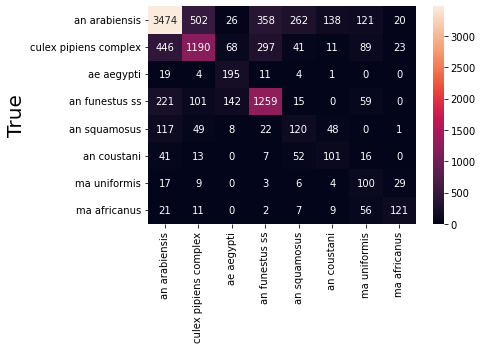

epoch = 37batch = 0 of 1008duraation = 0.0294754425684611
epoch = 37batch = 200 of 1008duraation = 2.254870541890462
epoch = 37batch = 400 of 1008duraation = 4.459173798561096
epoch = 37batch = 600 of 1008duraation = 6.667061698436737
epoch = 37batch = 800 of 1008duraation = 8.880653262138367
epoch = 37batch = 1000 of 1008duraation = 11.083059748013815
..Overrun....no improvement
Epoch: 37, Train Loss: 0.14351531, Train f1: 0.93700016, Val Loss: 0.00616660, Val f1: 0.64558837, overrun_counter 0
epoch = 38batch = 0 of 1008duraation = 0.02971565326054891
epoch = 38batch = 200 of 1008duraation = 2.2549487590789794
epoch = 38batch = 400 of 1008duraation = 4.470559465885162
epoch = 38batch = 600 of 1008duraation = 6.679381827513377
epoch = 38batch = 800 of 1008duraation = 8.883213837941488
epoch = 38batch = 1000 of 1008duraation = 11.095448923110961
..Overrun....no improvement
Epoch: 38, Train Loss: 0.14636934, Train f1: 0.93970732, Val Loss: 0.00595384, Val f1: 0.64882565, overrun_counter 

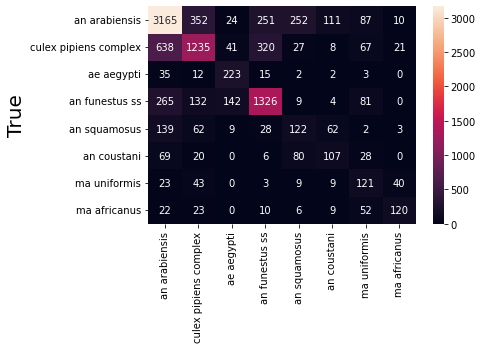

epoch = 40batch = 0 of 1008duraation = 0.031857160727183025
epoch = 40batch = 200 of 1008duraation = 2.2473095377286274
epoch = 40batch = 400 of 1008duraation = 4.457674984137217
epoch = 40batch = 600 of 1008duraation = 6.664467167854309
epoch = 40batch = 800 of 1008duraation = 8.876512277126313
epoch = 40batch = 1000 of 1008duraation = 11.077092305819194
..Overrun....no improvement
Epoch: 40, Train Loss: 0.13219758, Train f1: 0.94445073, Val Loss: 0.00632994, Val f1: 0.63688104, overrun_counter 0
epoch = 41batch = 0 of 1008duraation = 0.03728192249933879
epoch = 41batch = 200 of 1008duraation = 2.2604634006818136
epoch = 41batch = 400 of 1008duraation = 4.467349195480347
epoch = 41batch = 600 of 1008duraation = 6.675989905993144
epoch = 41batch = 800 of 1008duraation = 8.88322715361913
epoch = 41batch = 1000 of 1008duraation = 11.096380333105722
..Overrun....no improvement
Epoch: 41, Train Loss: 0.12813172, Train f1: 0.94991143, Val Loss: 0.00666875, Val f1: 0.64175834, overrun_counte

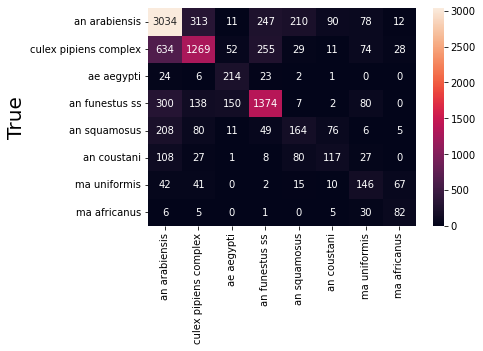

epoch = 43batch = 0 of 1008duraation = 0.034873624642690025
epoch = 43batch = 200 of 1008duraation = 2.250890866915385
epoch = 43batch = 400 of 1008duraation = 4.450384287039439
epoch = 43batch = 600 of 1008duraation = 6.651108074188232
epoch = 43batch = 800 of 1008duraation = 8.866988376776378
epoch = 43batch = 1000 of 1008duraation = 11.076592191060383
..Overrun....no improvement
Epoch: 43, Train Loss: 0.11980613, Train f1: 0.94982284, Val Loss: 0.00644555, Val f1: 0.64218633, overrun_counter 0
epoch = 44batch = 0 of 1008duraation = 0.033028268814086915
epoch = 44batch = 200 of 1008duraation = 2.2501826643943788
epoch = 44batch = 400 of 1008duraation = 4.460353589057922
epoch = 44batch = 600 of 1008duraation = 6.651608550548554
epoch = 44batch = 800 of 1008duraation = 8.861673843860626
epoch = 44batch = 1000 of 1008duraation = 11.056110354264577
Epoch: 44, Train Loss: 0.13362803, Train f1: 0.95037963, Val Loss: 0.00600850, Val f1: 0.66862343, overrun_counter -1
Saving model to: ../..

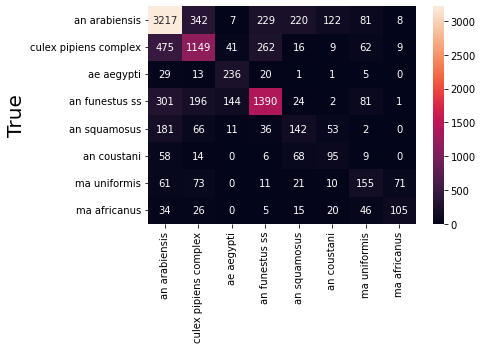

epoch = 45batch = 0 of 1008duraation = 0.02777094046274821
epoch = 45batch = 200 of 1008duraation = 2.244598615169525
epoch = 45batch = 400 of 1008duraation = 4.4514186183611555
epoch = 45batch = 600 of 1008duraation = 6.662954501310984
epoch = 45batch = 800 of 1008duraation = 8.868759286403655
epoch = 45batch = 1000 of 1008duraation = 11.07697940270106
..Overrun....no improvement
Epoch: 45, Train Loss: 0.11681234, Train f1: 0.95279435, Val Loss: 0.00651513, Val f1: 0.66055669, overrun_counter 0
epoch = 46batch = 0 of 1008duraation = 0.0332931915918986
epoch = 46batch = 200 of 1008duraation = 2.2486098806063333
epoch = 46batch = 400 of 1008duraation = 4.455963329474131
epoch = 46batch = 600 of 1008duraation = 6.659710284074148
epoch = 46batch = 800 of 1008duraation = 8.856175764401753
epoch = 46batch = 1000 of 1008duraation = 11.049955427646637
..Overrun....no improvement
Epoch: 46, Train Loss: 0.11671086, Train f1: 0.95389882, Val Loss: 0.00657941, Val f1: 0.64838861, overrun_counter 

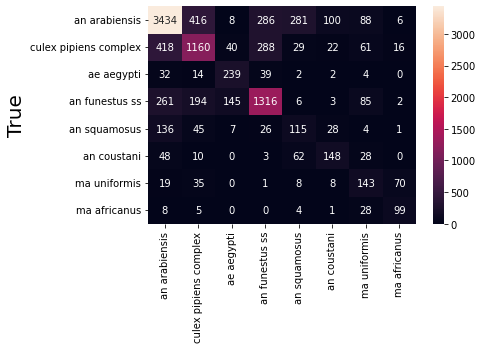

epoch = 93batch = 0 of 1008duraation = 0.03183681964874267
epoch = 93batch = 200 of 1008duraation = 2.255388124783834
epoch = 93batch = 400 of 1008duraation = 4.467111019293467
epoch = 93batch = 600 of 1008duraation = 6.680766491095225
epoch = 93batch = 800 of 1008duraation = 8.897594237327576
epoch = 93batch = 1000 of 1008duraation = 11.10391842921575
..Overrun....no improvement
Epoch: 93, Train Loss: 0.04860060, Train f1: 0.98372384, Val Loss: 0.00785045, Val f1: 0.66399399, overrun_counter 0
epoch = 94batch = 0 of 1008duraation = 0.02832470734914144
epoch = 94batch = 200 of 1008duraation = 2.253794614473979
epoch = 94batch = 400 of 1008duraation = 4.477005815505981
epoch = 94batch = 600 of 1008duraation = 6.693058971563975
epoch = 94batch = 800 of 1008duraation = 8.91001237630844
epoch = 94batch = 1000 of 1008duraation = 11.121267338593801
..Overrun....no improvement
Epoch: 94, Train Loss: 0.04944291, Train f1: 0.98316433, Val Loss: 0.00849210, Val f1: 0.64941584, overrun_counter 1


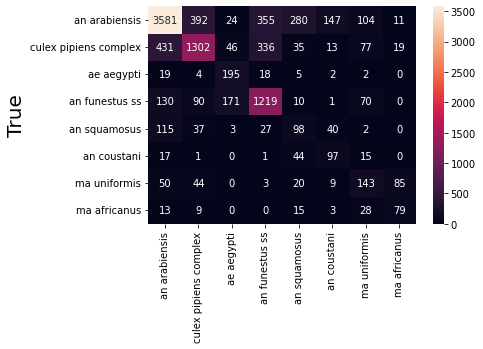

epoch = 122batch = 0 of 1008duraation = 0.03332216342290242
epoch = 122batch = 200 of 1008duraation = 2.257215134302775
epoch = 122batch = 400 of 1008duraation = 4.452035931746165
epoch = 122batch = 600 of 1008duraation = 6.668395845095317
epoch = 122batch = 800 of 1008duraation = 8.874370074272155
epoch = 122batch = 1000 of 1008duraation = 11.091677252451579
..Overrun....no improvement
Epoch: 122, Train Loss: 0.04211883, Train f1: 0.98685383, Val Loss: 0.00896038, Val f1: 0.64914934, overrun_counter 0
epoch = 123batch = 0 of 1008duraation = 0.03316952387491862
epoch = 123batch = 200 of 1008duraation = 2.2559849977493287
epoch = 123batch = 400 of 1008duraation = 4.453823904196422
epoch = 123batch = 600 of 1008duraation = 6.661482461293539
epoch = 123batch = 800 of 1008duraation = 8.863871848583221
epoch = 123batch = 1000 of 1008duraation = 11.063378063837687
..Overrun....no improvement
Epoch: 123, Train Loss: 0.03990384, Train f1: 0.98750517, Val Loss: 0.00872816, Val f1: 0.65566318, o

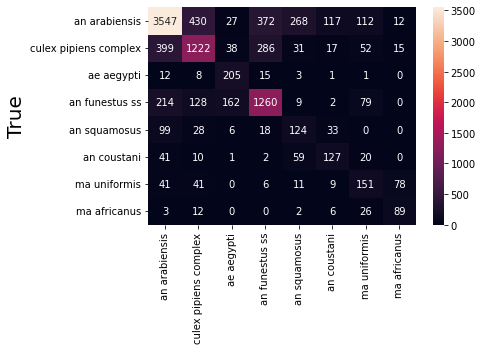

epoch = 187batch = 0 of 1008duraation = 0.0309159517288208
epoch = 187batch = 200 of 1008duraation = 2.2646485328674317
epoch = 187batch = 400 of 1008duraation = 4.477992288271586
epoch = 187batch = 600 of 1008duraation = 6.689952067534128
epoch = 187batch = 800 of 1008duraation = 8.90122134288152
epoch = 187batch = 1000 of 1008duraation = 11.108252620697021
..Overrun....no improvement
Epoch: 187, Train Loss: 0.02515350, Train f1: 0.99193736, Val Loss: 0.00857644, Val f1: 0.66339974, overrun_counter 0
epoch = 188batch = 0 of 1008duraation = 0.027557754516601564
epoch = 188batch = 200 of 1008duraation = 2.245858828226725
epoch = 188batch = 400 of 1008duraation = 4.4622265815734865
epoch = 188batch = 600 of 1008duraation = 6.672227227687836
epoch = 188batch = 800 of 1008duraation = 8.884499573707581
epoch = 188batch = 1000 of 1008duraation = 11.087295353412628
..Overrun....no improvement
Epoch: 188, Train Loss: 0.02528521, Train f1: 0.99178367, Val Loss: 0.00953581, Val f1: 0.66534627, o

In [66]:
model =Model('convnext_xlarge_in22k',224)
#filepath = "../../models/model_e73_2022_10_08_07_44_27.pth"
#model_epcoh_99 = load_model(filepath,model)
model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1 = train_model(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )

In [72]:
print(len(all_train_f1))
print(len(all_val_f1))
print(len(all_val_loss))
print(len(all_train_loss))


400
400
400
200


In [67]:
import torch
x,b = torchaudio.load("../../data/audio/221529.wav")

In [68]:
val_dataset_new = MozTestDataset(df_val_offset,  config.data_dir, min_length)
val_loader_new = torch.utils.data.DataLoader(
        val_dataset, batch_size=2,
        num_workers=0, pin_memory=pin_memory  )



In [69]:
val_iter = iter(val_loader_new)
x1,y1 = val_iter.next()
print(x1.shape)
model = model_epcoh_10
model.to('cuda')
x_g = x1.to('cuda')
model(x_g)

torch.Size([2, 1, 15360])


NameError: name 'model_epcoh_10' is not defined

In [ ]:
df_error = df_val_offset
model = model_epcoh_10
model.to('cuda')
model.eval()
for idx,(x,y) in enumerate(val_dataset):
    print(idx)
    print(y)
    x = x.to('cuda').float()
    print("x shape = " +str(x.shape))
    #x_new = x.unsqueeze(dim = 1)
    print("x_new shape = " +str(x_new.shape))
    x_new = x.to('cuda')
    y_pred = model(x_new)['prediction']
    y_pred_cpu = y_pred.cpu().detach()
    preds = torch.argmax(y_pred_cpu, axis = 1)
    df_erroriloc[idx]['y_hat'] = preds
    del x_new
    

    

In [ ]:
x = torch.rand(1,15360)
x = x.unsqueeze(dim = 1)

In [ ]:
df_val_offset.head()
path_temp = "../data/audio/"
for i,row in df_val_offset.iterrows():
    print("i = " +str(i))
    print("id = " + str(int(row['id'])))
    file = str(int(row['id']))+".wav"
    print(file)
    path = path_temp + file
    waveform, inp_rate = torchaudio.load(path)
    if inp_rate != config.rate:
        import torchaudio.transforms as T
        resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
        waveform = resampler(waveform)
    if waveform.shape[1] < config.rate*min_length:
        #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
        f_out = pad_mean(waveform)
    else:
        f = waveform[0]
        f_out = f.unsqueeze(0)
    
    
               

In [ ]:
def get_tensor(df):
    
    path_name = "../data/audio/"
    file = df.loc[idx]['id'])}.wav")
    waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("")
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        
        if DEBUG:
            print("shape of x post augmentation = " + str(x.shape))
            
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("returning x of shape ..." + str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [ ]:
#Take the model checkpoint as a parameter as input
# read the val df
#get the tensor rep for the offset.
#pass it to the model get add get the prediction.


In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))